# 4. 割引クーポンのキャンペーンの効果最大化

予算を１００万円として、全会員に次の3種類のダイレクトメールのいずれかを送付する。
1. セールのチラシのみ
2. セールのチラシと1000円のクーポン
3. セールのチラシと2000円のクーポン

次回以降の割引クーポンキャンペーンで利用する来店率のデータを一定数取得するため、各パターンのダイレクトメールを、類似した来店傾向の会員をグルーピングしたセグメントごとに、10％以上ずつ送付する。

セグメントは、年齢区分（4区分）と昨年度利用回数区分（4区分）の組み合わせで与えられる。

1. 各会員に対してどのパターンのダイレクトメールを送付するかを決定
2. 各会員に対して送付するダイレクトメールはいずれか1パターン
3. クーポン付与による来客増加数を最大化する
4. 会員の予算消費期待値の合計は100万円以下（キャンペーン予算）
5. 各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10％以上に送付


<AxesSubplot: >

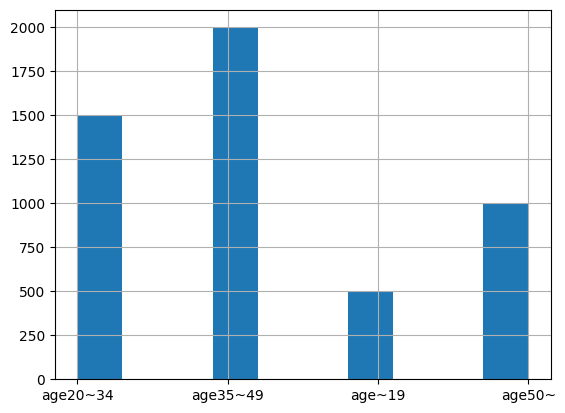

In [1]:
import pandas as pd

cust_df = pd.read_csv("data/customers.csv")
cust_df["age_cat"].hist()

<AxesSubplot: >

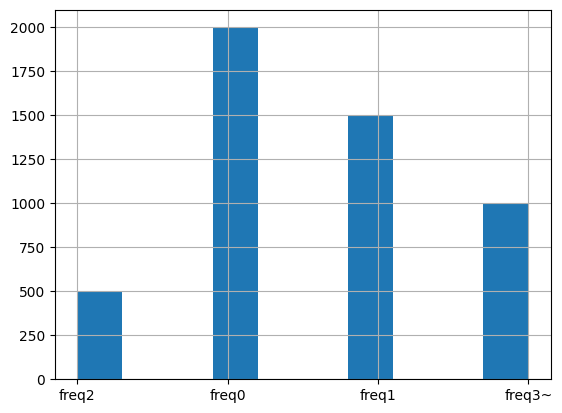

In [3]:
cust_df["freq_cat"].hist()

In [4]:
cust_pivot_df = pd.pivot_table(data=cust_df, values="customer_id", columns="freq_cat", index="age_cat", aggfunc="count")
cust_pivot_df = cust_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<AxesSubplot: xlabel='freq_cat', ylabel='age_cat'>

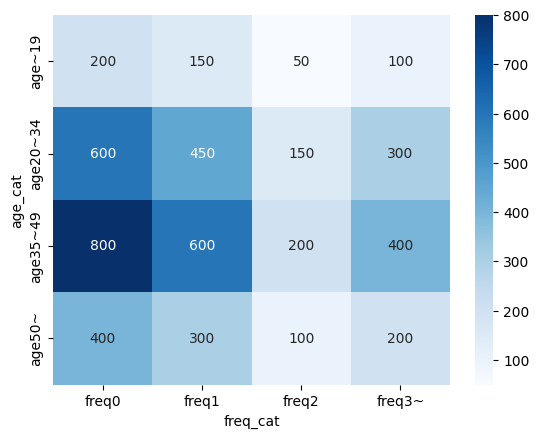

In [5]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt="d", cmap="Blues")

In [6]:
# 来店率データの確認
prob_df = pd.read_csv("data/visit_probability.csv")
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


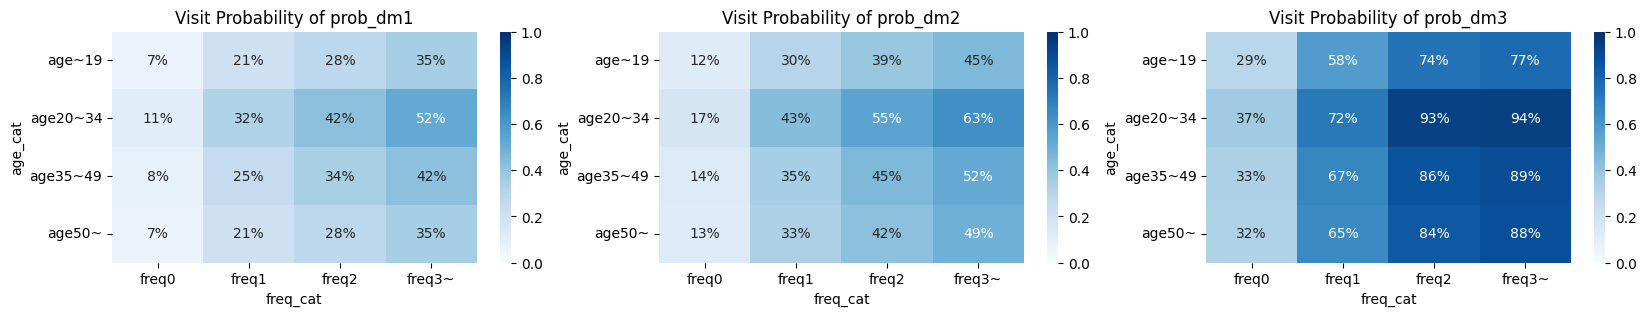

In [7]:
import matplotlib.pyplot as plt

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(["prob_dm1", "prob_dm2", "prob_dm3"]):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns="freq_cat", index="age_cat")
    prob_pivot_df = prob_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt=".0%", cmap="Blues", ax=ax[i])
    ax[i].set_title(f"Visit Probability of {ptn}")
plt.show()

### モデリング１：会員個別送付モデル

In [8]:
import pulp

problem = pulp.LpProblem(name="DiscountCouponProblem1", sense=pulp.LpMaximize)

# 会員IDのリスト
I = cust_df["customer_id"].tolist()

# ダイレクトメールのパターンのリスト
M = [1, 2, 3]

# 1. 各会員に対してどのパターンのダイレクトメールを送付するかを決定
xim = {}
for i in I:
    for m in M:
        xim[i, m] = pulp.LpVariable(name=f"xim({i}, {m})", cat="Binary")

# 2. 各会員に対して送付するダイレクトメールはいずれか1パターン
for i in I:
    problem += pulp.lpSum(xim[i, m] for m in M) == 1

# 会員データと来店率データを年齢区分と昨年度来店回数区分の列をキーとして結合し、
# 各会員にそれぞれのパターンのダイレクトメールを送付した時の来店率を得る。
cust_prob_df = pd.merge(cust_df, prob_df, on=["age_cat", "freq_cat"])

# 会員IDとダイレクトメールパターンに対しtidyなフォーマットにする
cust_prob_ver_df = cust_prob_df.rename(
        columns={"prob_dm1": 1, "prob_dm2": 2, "prob_dm3": 3}
    ).melt(
        id_vars=["customer_id"], value_vars=[1, 2, 3], var_name="dm", value_name="prob"
    )

# 会員iとダイレクトメールのパターンmの組をキーとして、来店率を返す辞書Pimを定義する。
Pim = cust_prob_ver_df.set_index(["customer_id", "dm"])["prob"].to_dict()

# 3. クーポン付与による来客増加数を最大化（m=1のときは考慮不要）
problem += pulp.lpSum((Pim[i, m] - Pim[i, 1]) * xim[i, m] for i in I for m in [2, 3])

# 4. 顧客の消費する費用の期待値の合計は100万円以下
Cm = {1: 0, 2: 1000, 3: 2000}
problem += pulp.lpSum(Cm[m] * Pim[i, m] * xim[i, m] for i in I for m in [2, 3]) <= 1000000

# セグメントのリスト
S = prob_df["segment_id"].to_list()

# 各セグメントとそのセグメントに属する顧客数を対応させる辞書
Ns = cust_prob_df.groupby("segment_id")["customer_id"].count().to_dict()

# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index("customer_id")["segment_id"].to_dict()

# 5. 各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10％以上に送付
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i, m] for i in I if Si[i] == s) >= 0.1 * Ns[s]

※注：下記の求解はデフォルトの設定では自分のPCでは計算が終わらなかった

options=["maxsol 3"]とすることで、暫定解が3つ見つかったところで計算を終了。

その他のCBCソルバーのオプション
- mip=1：　解きたい問題に整数変数が含まれる場合は１にする。
- maxSecondsは最大計算時間を秒で指定できる
- threadsはソルバー実行の並列数を設定できる（pulpデフォルトのCBCでは無効？） 
- optionsではそれ以外のオプションを設定できる。

In [9]:
import time
time_start = time.time()
status = problem.solve(pulp.PULP_CBC_CMD(msg=0, options=["maxsol 3"]))
time_stop = time.time()
print(f"Status:{pulp.LpStatus[status]}")
print(f"Objective:{pulp.value(problem.objective):.4}")
print(f"Time:{(time_stop - time_start):.3}(sec)")

Status:Optimal
Objective:326.1
Time:3.07(sec)


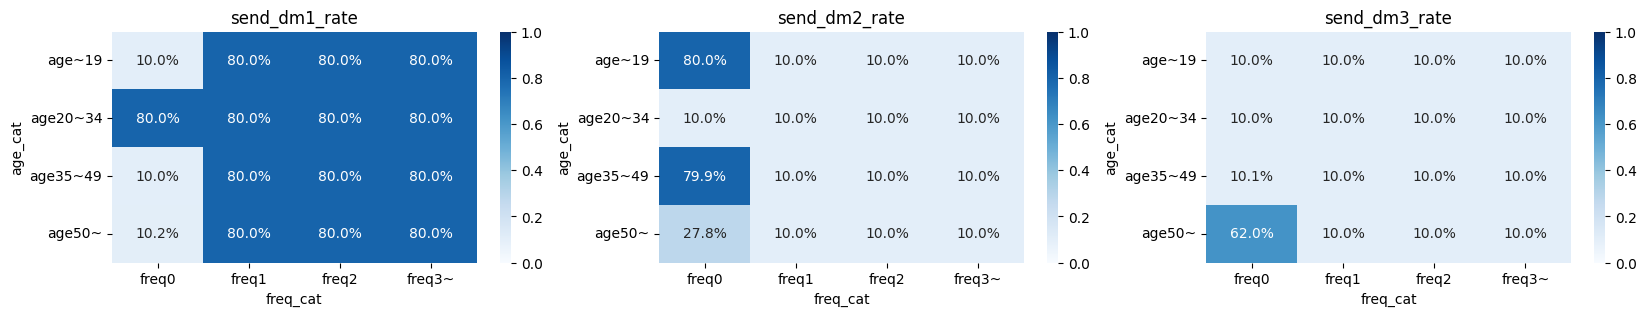

In [10]:
send_dm_df = pd.DataFrame([[xim[i, m].value() for m in M] for i in I],
    columns=["send_dm1", "send_dm2", "send_dm3"])

cust_send_df = pd.concat([cust_df[["customer_id", "age_cat", "freq_cat"]], send_dm_df], axis=1)

# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(["send_dm1", "send_dm2", "send_dm3"]):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns="freq_cat", index="age_cat", aggfunc="mean")
    cust_send_pivot_df = cust_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt=".1%", cmap="Blues", vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f"{ptn}_rate")
plt.show()

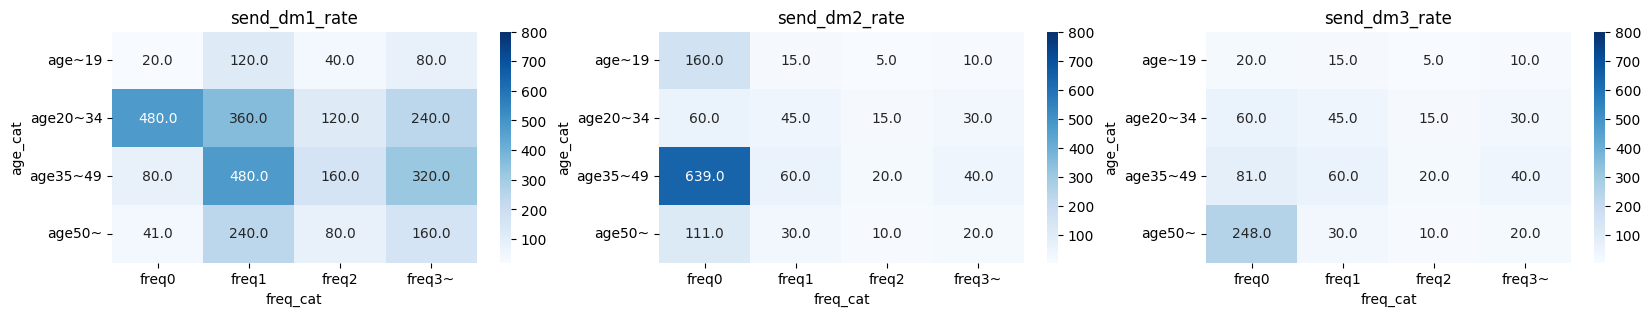

In [11]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(["send_dm1", "send_dm2", "send_dm3"]):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns="freq_cat", index="age_cat", aggfunc="sum")
    cust_send_pivot_df = cust_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt=".1f", cmap="Blues", vmax=800, ax=ax[i])
    ax[i].set_title(f"{ptn}_rate")
plt.show()

### モデリング２：セグメント送付モデル

In [12]:
problem = pulp.LpProblem(name="DiscountCouponProblem2", sense=pulp.LpMaximize)

# 1. 各会員に対してどのパターンのダイレクトメールを送付するかを決定する
# 個人に対する送付有無ではなく、セグメントに対する送付率なので[0, 1]の連続値
xsm = {}
for s in S:
    for m in M:
        xsm[s, m] = pulp.LpVariable(name=f"xsm({s}, {m})", lowBound=0, upBound=1, cat="Continuous")

# 2. 各会員に対して送付するダイレクトメールはいずれか1パターン
# セグメントに関しては、各セグメントに送付するダイレクトメールパターンの送付率の和が100％
for s in S:
    problem += pulp.lpSum(xsm[s, m] for m in M) == 1

# セグメントsに対しパターン　ｍ のＤＭを送付した時雄来店率Psmを定義
prob_ver_df = prob_df.rename(
    columns={"prob_dm1": 1, "prob_dm2": 2, "prob_dm3": 3}
).melt(
    id_vars=["segment_id"], value_vars=[1, 2, 3], var_name="dm", value_name="prob"
)
Psm = prob_ver_df.set_index(["segment_id", "dm"])["prob"].to_dict()

# 3. クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3])

# 4. 会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= 1000000

# 5. 各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10％以上に送付
for s in S:
    for m in M:
        problem += xsm[s, m] >= 0.1

In [13]:
time_start = time.time()
status = problem.solve(pulp.PULP_CBC_CMD(msg=0))
time_stop = time.time()

print(f"Status:{pulp.LpStatus[status]}")
print(f"Objective:{pulp.value(problem.objective):.4}")
print(f"Time:{(time_stop - time_start):.3}(sec)")

Status:Optimal
Objective:326.1
Time:0.00787(sec)


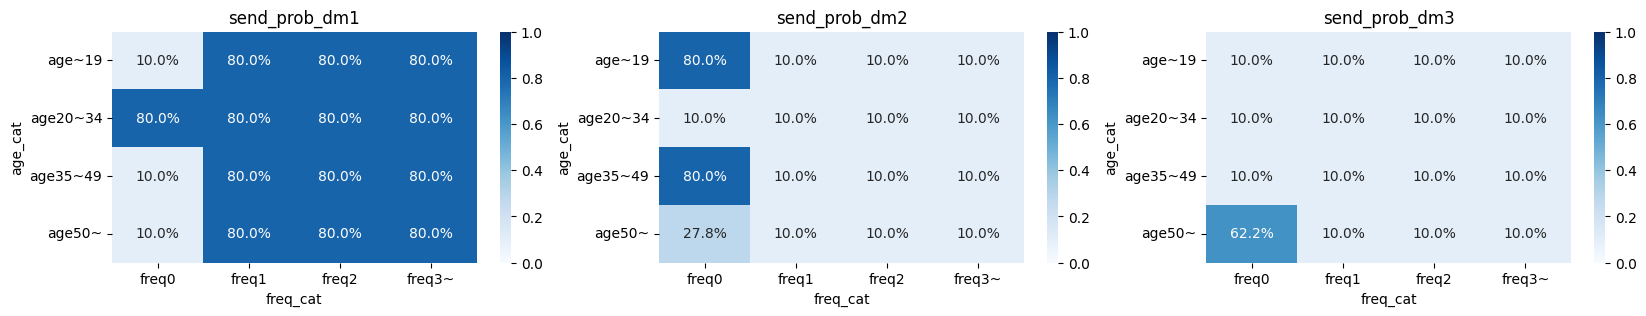

In [14]:
send_dm_df = pd.DataFrame([[xsm[s, m].value() for m in M] for s in S], columns=["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"])
seg_send_df = pd.concat([prob_df[["segment_id", "age_cat", "freq_cat"]], send_dm_df], axis=1)

# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"]):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns="freq_cat", index="age_cat", aggfunc="mean")
    seg_send_pivot_df = seg_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt=".1%", cmap="Blues", vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f"{ptn}")
plt.show()

In [15]:
seg_send_df["num_cust"] = seg_send_df["segment_id"].apply(lambda x: Ns[x])
seg_send_df["send_num_dm1"] = seg_send_df["send_prob_dm1"] * seg_send_df["num_cust"]
seg_send_df["send_num_dm2"] = seg_send_df["send_prob_dm2"] * seg_send_df["num_cust"]
seg_send_df["send_num_dm3"] = seg_send_df["send_prob_dm3"] * seg_send_df["num_cust"]
seg_send_df[["segment_id", "send_num_dm1", "send_num_dm2", "send_num_dm3"]].head()

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.0,20.0
1,2,120.0,15.0,15.0
2,3,40.0,5.0,5.0
3,4,80.0,10.0,10.0
4,5,480.0,60.0,60.0


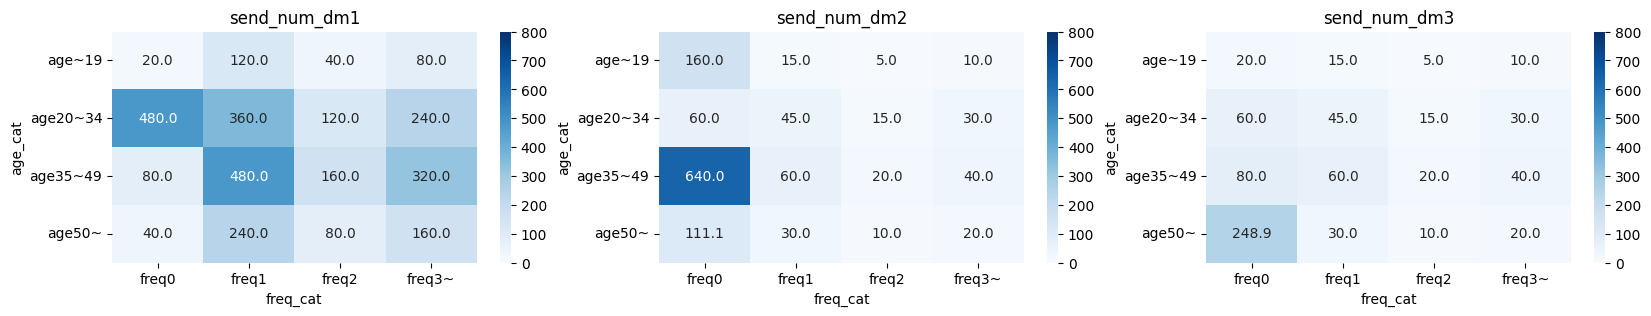

In [16]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(["send_num_dm1", "send_num_dm2", "send_num_dm3"]):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns="freq_cat", index="age_cat", aggfunc="sum")
    # aggfuncはsumでもmeanでも同じ
    seg_send_pivot_df = seg_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt=".1f", cmap="Blues", vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f"{ptn}")
plt.show()

### モデリング３：送付率下限値最大化モデル

In [18]:
problem = pulp.LpProblem(name="DiscountCouponProblem3", sense=pulp.LpMaximize)

# 会員に対してどのダイレクトメールを送付するか
xsm = {}
# [0, 1]の変数を宣言
for s in S:
    for m in M:
        xsm[s, m] = pulp.LpVariable(name=f"xsm({s}, {m})", lowBound=0, upBound=1, cat="Continuous")

# 各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値
y = pulp.LpVariable(name="y", lowBound=0, upBound=1, cat="Continuous")

# 3. 各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値を最大化
problem += y

# 5. 各パターンのダイレクトメールを設定した送付率の下限値以上送付する
for s in S:
    for m in M:
        problem += xsm[s, m] >= y

# 2. 各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s, m] for m in M) == 1

# 4. 会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= 1000000


In [19]:
status = problem.solve(pulp.PULP_CBC_CMD(msg=0))
max_lowerbound = pulp.value(problem.objective)
print(f"Status:{pulp.LpStatus[status]}, Objective:{max_lowerbound:.3}")

Status:Optimal, Objective:0.131


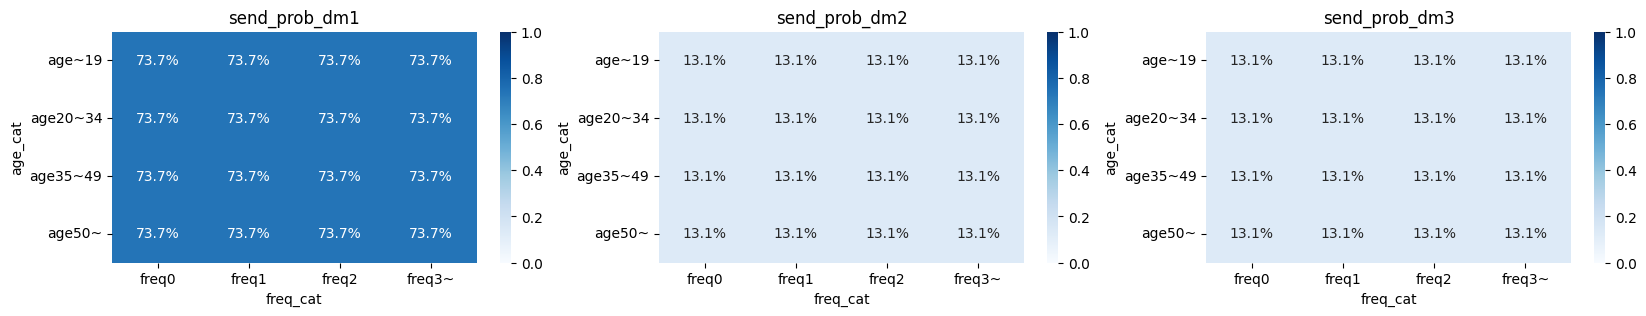

In [22]:
send_dm_df = pd.DataFrame([[xsm[s, m].value() for m in M] for s in S], columns=["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"])
seg_send_df = pd.concat([prob_df[["segment_id", "age_cat", "freq_cat"]], send_dm_df], axis=1)

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"]):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns="freq_cat", index="age_cat", aggfunc="mean")
    seg_send_pivot_df = seg_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt=".1%", cmap="Blues", vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f"{ptn}")
plt.show()

In [23]:
problem = pulp.LpProblem(name="DiscountCouponProblem3", sense=pulp.LpMaximize)

# 会員に対してどのダイレクトメールを送付するか
xsm = {}
for s in S:
    for m in M:
        xsm[s, m] = pulp.LpVariable(name=f"xsm({s}, {m})", lowBound=0, upBound=1, cat="Continuous")

# 2. 各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s, m] for m in M) == 1

# 3. クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3])

# 4. 会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= 1000000

# 5. 各パターンのダイレクトメールを設定した送付率の下限値以上送付
for s in S:
    for m in M:
        problem += xsm[s, m] >= max_lowerbound

In [24]:
status = problem.solve(pulp.PULP_CBC_CMD(msg=0))
print(f"Status:{pulp.LpStatus[status]}, Objective:{pulp.value(problem.objective):.4}")

Status:Optimal, Objective:300.6


### 投資対効果の評価

In [26]:
cost_list = []
cpa_list = []
inc_action_list = []  # 来客増加数のリスト

print("ステータス、キャンペーン費用、来客増加数、CPA")
for cost in range(761850, 3000000, 100000):
    problem = pulp.LpProblem(name="DiscountCouponProblem2", sense=pulp.LpMaximize)

    # 会員に対してどのダイレクトメールを送付するか
    xsm = {}
    for s in S:
        for m in M:
            xsm[s, m] = pulp.LpVariable(name=f"xsm({s}, {m})", lowBound=0, upBound=1, cat="Continuous")
    
    # 2. 各会員に対して送付するダイレクトメールはいずれか1パターン
    for s in S:
        problem += pulp.lpSum(xsm[s, m] for m in M) == 1
    
    # 3. 割引権付与による来客増加数を最大化
    problem += pulp.lpSum(Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3])

    # 4. 会員の予算消費期待値の合計はcost以下
    problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= cost

    # 5. 各パターンのダイレクトメールを設定した送付率の下限値以上送付
    for s in S:
        for m in M:
            problem += xsm[s, m] >= 0.1
    
    status = problem.solve(pulp.PULP_CBC_CMD(msg=0))
    inc_action = pulp.value(problem.objective)
    cpa = cost / inc_action

    cost_list.append(cost)
    cpa_list.append(cpa)
    inc_action_list.append(inc_action)

    print(f"{pulp.LpStatus[status]}, {cost}, {inc_action:.4}, {cpa:.5}")

ステータス、キャンペーン費用、来客増加数、CPA
Optimal, 761850, 229.0, 3326.9
Optimal, 861850, 273.1, 3156.3
Optimal, 961850, 311.9, 3084.0
Optimal, 1061850, 349.1, 3042.0
Optimal, 1161850, 385.8, 3011.8
Optimal, 1261850, 422.3, 2988.0
Optimal, 1361850, 458.8, 2968.0
Optimal, 1461850, 495.2, 2951.8
Optimal, 1561850, 530.5, 2944.2
Optimal, 1661850, 565.6, 2938.4
Optimal, 1761850, 600.7, 2933.2
Optimal, 1861850, 634.2, 2935.9
Optimal, 1961850, 667.3, 2940.2
Optimal, 2061850, 700.2, 2944.5
Optimal, 2161850, 732.5, 2951.4
Optimal, 2261850, 764.1, 2960.1
Optimal, 2361850, 795.5, 2969.2
Optimal, 2461850, 826.8, 2977.5
Optimal, 2561850, 858.1, 2985.3
Optimal, 2661850, 889.5, 2992.6
Optimal, 2761850, 920.8, 2999.3
Optimal, 2861850, 951.7, 3007.1
Optimal, 2961850, 981.9, 3016.4


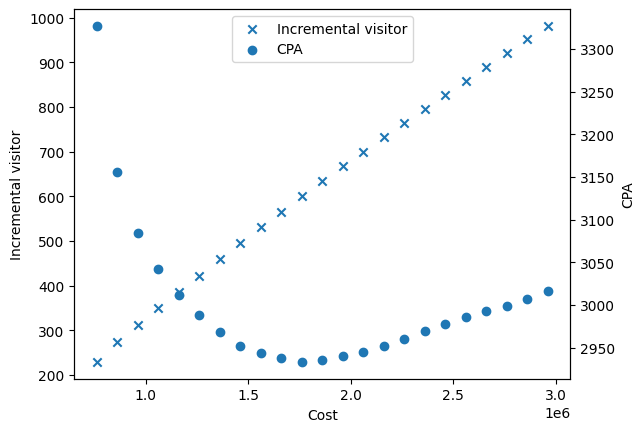

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker="x", label="Incremental visitor")
ax2.scatter(cost_list, cpa_list, label="CPA")
ax1.set_xlabel("Cost")
ax1.set_ylabel("Incremental visitor")
ax2.set_ylabel("CPA")
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc="upper center")
plt.show()